### Unsupervised Learning : Clustering

#### Number of Clusters for Gaussian Mixtures

/home/lokesh/.local/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


100 points convergence: [True, True, True, True, True, True, True]
1000 points convergence: [True, True, True, True, True, True, True]
10000 points convergence: [True, True, True, True, True, True, True]


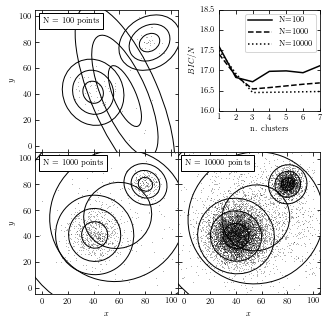

In [3]:
from __future__ import print_function, division

import numpy as np
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from astroML.utils import convert_2D_cov
from astroML.plotting.tools import draw_ellipse


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


# Set up the dataset
# we'll define clusters as (mu, sigmal, sigma2, alpha, frac)
clusters = [((50, 50), 20, 20, 0, 0.1),
            ((40, 40), 10, 10, np.pi / 6, 0.6),
            ((80, 80), 5, 5, np.pi / 3, 0.2),
            ((60, 60), 30, 30, 0, 0.1)]

gmm_input = GaussianMixture(len(clusters), covariance_type='full')
gmm_input.means_ = np.array([c[0] for c in clusters])
gmm_input.covariances_ = np.array([convert_2D_cov(*c[1:4]) for c in clusters])
gmm_input.weights_ = np.array([c[4] for c in clusters])
gmm_input.weights_ /= gmm_input.weights_.sum()
gmm_input.precisions_cholesky_ = 1 / np.sqrt(gmm_input.covariances_)
gmm_input.fit = None

# Compute and plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.11, right=0.9, bottom=0.11, top=0.9,
                    hspace=0, wspace=0)
ax_list = [fig.add_subplot(s) for s in [221, 223, 224]]
ax_list.append(fig.add_axes([0.62, 0.62, 0.28, 0.28]))

linestyles = ['-', '--', ':']

grid = np.linspace(-5, 105, 70)
Xgrid = np.array(np.meshgrid(grid, grid))
Xgrid = Xgrid.reshape(2, -1).T

Nclusters = np.arange(1, 8)
for Npts, ax, ls in zip([100, 1000, 10000], ax_list, linestyles):
    np.random.seed(1)
    X = gmm_input.sample(Npts)[0]

    # find best number of clusters via BIC
    clfs = [GaussianMixture(N, max_iter=500).fit(X)
            for N in Nclusters]
    BICs = np.array([clf.bic(X) for clf in clfs])
    print("{0} points convergence:".format(Npts),
          [clf.converged_ for clf in clfs])

    # plot the BIC
    ax_list[3].plot(Nclusters, BICs / Npts, ls, c='k',
                    label="N=%i" % Npts)

    clf = clfs[np.argmin(BICs)]
    log_dens = clf.score_samples(Xgrid).reshape((70, 70))

    # scatter the points
    ax.plot(X[:, 0], X[:, 1], ',k', alpha=0.3, zorder=1)

    # plot the components
    for i in range(clf.n_components):
        mean = clf.means_[i]
        cov = clf.covariances_[i]
        if cov.ndim == 1:
            cov = np.diag(cov)
        draw_ellipse(mean, cov, ax=ax, fc='none', ec='k', zorder=2)

    # label the plot
    ax.text(0.05, 0.95, "N = %i points" % Npts,
            ha='left', va='top', transform=ax.transAxes,
            bbox=dict(fc='w', ec='k'))

    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)


ax_list[0].xaxis.set_major_formatter(plt.NullFormatter())
ax_list[2].yaxis.set_major_formatter(plt.NullFormatter())

for i in (0, 1):
    ax_list[i].set_ylabel('$y$')

for j in (1, 2):
    ax_list[j].set_xlabel('$x$')

ax_list[-1].legend(loc=1)

ax_list[-1].set_xlabel('n. clusters')
ax_list[-1].set_ylabel('$BIC / N$')
ax_list[-1].set_ylim(16, 18.5)

plt.show()

### EM example : K-Means

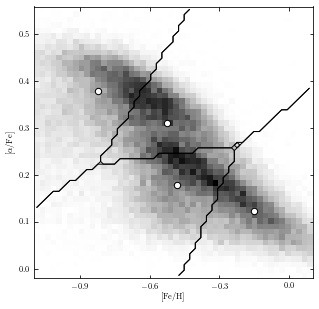

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import KMeans
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


# Get data
data = fetch_sdss_sspp(cleaned = True)
X = np.vstack([data['FeH'], data['alphFe']]).T

# truncate dataset for speed
X = X[::5]

# Compute a 2D histogram of the input
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 50)

# Compute the KMeans clustering
n_clusters = 4

scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X))

# Visualize the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# plot density
ax = plt.axes()
ax.imshow(H.T, origin= 'lower', interpolation='nearest', aspect='auto',
         extent  = [FeH_bins[0], FeH_bins[-1],
                    alphFe_bins[0], alphFe_bins[-1]],
         cmap = plt.cm.binary)

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
FeH_centers = 0.5 * (FeH_bins[1:] + FeH_bins[:-1])
alphFe_centers = 0.5 * (alphFe_bins[1:] + alphFe_bins[:-1])

Xgrid = np.meshgrid(FeH_centers, alphFe_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(FeH_centers, alphFe_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])

ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()

### Mean Shift

/home/lokesh/.local/lib/python3.5/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/lokesh/.local/lib/python3.5/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


[-1  0  1]
0.4
number of estimated clusters : 2


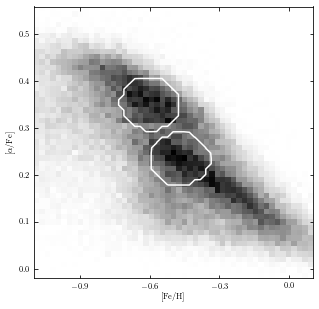

In [8]:
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import preprocessing

from astroML.datasets import fetch_sdss_sspp

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

# Get the data
np.random.seed(0)
data = fetch_sdss_sspp(cleaned = True)

# cut out some additional strange outliers
data = data[~((data['alphFe'] > 0.4) & (data['FeH'] > -0.3))]

X = np.vstack([data['FeH'], data['alphFe']]).T

# Compute clustering with MeanShift

X_scaled = preprocessing.scale(X)

# bandwidth = estimate_bandwidth(X)
bandwidth = 0.4

ms = MeanShift(bandwidth=bandwidth, bin_seeding = True, cluster_all = False)
ms.fit(X_scaled)

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Plot the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

# plot density
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'], 51)

ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[FeH_bins[0], FeH_bins[-1],
                  alphFe_bins[0], alphFe_bins[-1]],
          cmap=plt.cm.binary)

# plot clusters
colors = ['b', 'g', 'r', 'k']

for i in range(n_clusters):
    Xi = X[ms.labels_ == i]
    H, b1, b2 = np.histogram2d(Xi[:, 0], Xi[:, 1], (FeH_bins, alphFe_bins))

    bins = [0.1]

    ax.contour(0.5 * (FeH_bins[1:] + FeH_bins[:-1]),
               0.5 * (alphFe_bins[1:] + alphFe_bins[:-1]),
               H.T, bins, colors='w')

ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlim(-1.101, 0.101)
ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
ax.set_xlabel(r'$\rm [Fe/H]$')
ax.set_ylabel(r'$\rm [\alpha/Fe]$')

plt.show()